In [77]:
#%matplotlib notebook

import re

import gemmi
import numpy as np
import reciprocalspaceship as rs
from glob import glob
from natsort import natsorted

from scipy.stats import differential_entropy
from scipy.stats import kurtosis
from scipy.stats import binned_statistic

from matplotlib import pyplot as plt

import masks

In [98]:
def negentropy(X):
    """
    Return negentropy (float) of X (numpy array)
    """
    
    # negetropy is the difference between the entropy of samples x
    # and a Gaussian with same variance
    # http://gregorygundersen.com/blog/2020/09/01/gaussian-entropy/
    
    std = np.std(X)
    #neg_e = np.log(std*np.sqrt(2*np.pi*np.exp(1))) - differential_entropy(X)
    neg_e = 0.5 * np.log(2.0 * np.pi * std ** 2) + 0.5 - differential_entropy(X)
    #assert neg_e >= 0.0
    
    return neg_e


def mtz_to_stats(mtz_path, weight, labf='KFOFOWT', labphi='PHIKFOFOWT', masked=True):
    
    mtz = gemmi.read_mtz_file(mtz_path)
    grid = mtz.transform_f_phi_to_map(labf, labphi, sample_rate=3)
    if masked:
        grid = masks.FDA_and_TT_chainA_region_only(grid)

    x = np.array(grid).flatten()
    x = x[x != 0.0]

    return np.array([weight, negentropy(x), kurtosis(x)])


def wilson(dataset, Flab, bins=100):

    dataset['d'] = dataset.compute_dHKL()['dHKL']
    dataset = dataset[['d', Flab]]
    dataset = dataset.dropna(how='any')

    values, edges, _ = binned_statistic((1.0/ds['d'])**2, ds[Flab], bins=bins)
    bin_centers = (edges[1:] + edges[:-1]) / 2.0

    values[values <= 0.0] = 1e-32

    return values, bin_centers

In [99]:
basedir = '/Users/tjlane/Desktop/k-weight-deds/'

no_weight_mtz = basedir + '10ns_noW_mFoFo.mtz'
q_weight_mtz  = basedir + '10ns_qW_mqFoFo.mtz'
k_weight_mtzs = glob(basedir + '10ns_k*W_mkFoFo.mtz')

In [96]:
kwt_stats = np.zeros((len(k_weight_mtzs) + 2, 3))

kwt_stats[0,:] = mtz_to_stats(no_weight_mtz, -0.1, 'FOFOWT', 'PHIFOFOWT', masked=False)
kwt_stats[1,:] = mtz_to_stats(q_weight_mtz, 0.0, 'QFOFOWT', 'PHIQFOFOWT', masked=False)

for i,kw_mtz in enumerate(k_weight_mtzs):
    g = re.search(r'10ns_k(\d+)p(\d+)W_mkFoFo.mtz', kw_mtz)
    k_wt = float(g.group(1) + '.' +g.group(2))
    kwt_stats[i+2,:] = mtz_to_stats(kw_mtz, k_wt, masked=False)

kwt_stats = kwt_stats[np.argsort(kwt_stats[:,0]),:]

In [101]:
kwt_stats_masked = np.zeros((len(k_weight_mtzs) + 2, 3))

kwt_stats_masked[0,:] = mtz_to_stats(no_weight_mtz, -0.1, 'FOFOWT', 'PHIFOFOWT', masked=True)
kwt_stats_masked[1,:] = mtz_to_stats(q_weight_mtz, 0.0, 'QFOFOWT', 'PHIQFOFOWT', masked=True)

for i,kw_mtz in enumerate(k_weight_mtzs):
    g = re.search(r'10ns_k(\d+)p(\d+)W_mkFoFo.mtz', kw_mtz)
    k_wt = float(g.group(1) + '.' +g.group(2))
    kwt_stats_masked[i+2,:] = mtz_to_stats(kw_mtz, k_wt, masked=True)

kwt_stats_masked = kwt_stats_masked[np.argsort(kwt_stats_masked[:,0]),:]

/var/folders/s9/bht_sc9n7ys6m0q3h_3htntc0000gn/T/ipykernel_41679/2292449498.py:4: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(121)


<Figure size 640x480 with 0 Axes>

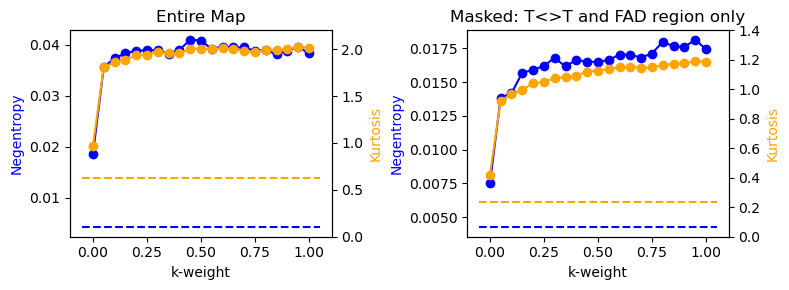

<Figure size 640x480 with 0 Axes>

In [117]:
plt.figure(figsize=(8,3))
plt.title('mask - TT region')

ax = plt.subplot(121)
ax.set_title('Entire Map')
p1 = ax.plot(kwt_stats[1:,0], kwt_stats[1:,1], color='blue')
ax.plot(kwt_stats[1:,0], kwt_stats[1:,1], 'o', color='blue')
ax.hlines(kwt_stats_masked[0,1], -0.05, 1.05, linestyle='--', color='blue')

plt.xlabel(r'k-weight')
ax.set_ylabel('Negentropy', color='blue')

ax2 = ax.twinx()
p2 = ax2.plot(kwt_stats[1:,0], kwt_stats[1:,2], color='orange')
ax2.plot(kwt_stats[1:,0], kwt_stats[1:,2], 'o', color='orange')
ax2.set_ylabel('Kurtosis', color='orange')
ax2.hlines(kwt_stats[0,2], -0.05, 1.05, linestyle='--', color='orange')
ax2.set_ylim([0,2.2])

ax = plt.subplot(122)
ax.set_title('Masked: T<>T and FAD region only')
p1 = ax.plot(kwt_stats_masked[1:,0], kwt_stats_masked[1:,1], color='blue')
ax.plot(kwt_stats_masked[1:,0], kwt_stats_masked[1:,1], 'o', color='blue')
ax.hlines(kwt_stats_masked[0,1], -0.05, 1.05, linestyle='--', color='blue')


plt.xlabel(r'k-weight')
ax.set_ylabel('Negentropy', color='blue')

ax2 = ax.twinx()
p2 = ax2.plot(kwt_stats_masked[1:,0], kwt_stats_masked[1:,2], color='orange')
ax2.plot(kwt_stats_masked[1:,0], kwt_stats_masked[1:,2], 'o', color='orange')
ax2.hlines(kwt_stats_masked[0,2], -0.05, 1.05, linestyle='--', color='orange')
ax2.set_ylim([0,1.4])
ax2.set_ylabel('Kurtosis', color='orange')

plt.tight_layout()
plt.savefig('k-weighting.pdf')
plt.savefig('k-weighting.png')
plt.savefig('k-weighting.eps')
plt.figure()

## wilson plot

In [ ]:
Flab = 'KFEXTR'
#ds = rs.read_mtz('../../pl-refinements/depositions/4_1ns/1ns_deposit.mtz')
ds = rs.read_mtz('../../2p0_10ns_light_139-146_full-merged-aniso_occ0.080_kFextr.mtz')
v, bc = wilson(ds, Flab)

In [ ]:
plt.figure()

ax = plt.subplot(111)

ax.plot((1.0/ds['d']) ** 2, ds[Flab], '.', color='grey', markersize=0.5)
ax.plot(bc, v, linewidth=2)

ax.set_yscale('symlog')

ax.set_xlabel('d$^2$')
ax.set_ylabel(f'log({Flab})')

ax.set_xlim([0, 0.2])
#ax.set_ylim([1e1, 1e5])

ax2 = ax.twiny()
ax2.set_xlim(ax.get_xlim())
ax2.set_xticks(ax.get_xticks())
ax2.set_xticklabels( [f'{t: .1f}' for t in 1.0/np.sqrt(ax.get_xticks())] )
ax2.set_xlabel(r"Resolution (A)")

plt.show()